In [6]:
import h5py
fp = h5py.File('train_fake_logits.h5','r')

In [32]:
ch = 0
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [39]:
len(fp["img_data"])

2501

In [33]:
fp["img_data"][ch].shape

(416, 416, 3)

In [34]:
fp["big_logits"][ch].shape

(13, 13, 3, 25)

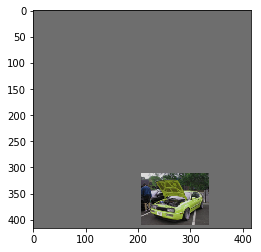

In [35]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(fp["img_data"][ch])
plt.show()

In [36]:
import numpy as np
lrg = fp["big_logits"][ch]

In [37]:
arrpl = lrg
arrpl[:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxl = np.where(arrpl[:,:,:,4] > 0 )
boxl

(array([11]), array([8]), array([0]))

In [38]:
box = boxl
arrp= arrpl
for i in range(len(box[0])):
    s = np.array(box)
    #print( i*5 )
    stp = i
   
    print( "({},{},{})".format(s[0,stp],s[1,stp],s[2,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

(11,8,0)
[0.6610577  0.87259614 0.2451923  0.19951923 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------


In [76]:
import numpy as np
import keras.backend as K
import h5py
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import preprocess_true_boxes, yolo_loss
from model.mobilenet import yolo_body
from model.yolo3 import  tiny_yolo_body
from model.utils  import get_random_data

import argparse

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''


    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        y_true = []
        bbox_data = []
        mbox_data = []
        sbox_data = []
        for b in range(batch_size):
            #if i==0:
                #np.random.shuffle(annotation_lines)
           # print(i)
           # print(annotation_lines[i][0].shape)
           # print(annotation_lines[i][1].shape)
            image, bbox , mbox ,sbox =  annotation_lines["img_data"][i] , annotation_lines["big_logits"][i] , annotation_lines["medium_logits"][i] , annotation_lines["small_logits"][i]  #get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            bbox_data.append(bbox)
            mbox_data.append(mbox)
            sbox_data.append(sbox)
            i = (i+1) % n
        image_data = np.array(image_data)
        bbox_data = np.array(bbox_data)
        mbox_data = np.array(mbox_data)
        sbox_data = np.array(sbox_data)
        y_true.append(bbox_data)
        y_true.append(mbox_data)
        y_true.append(sbox_data)
        #y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        #y_true = model.predict(image_data)
      
        yield image_data, y_true #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)


In [77]:
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw
    
train_lines =  h5py.File('train_fake_logits.h5','r') #np.load('train_logits.npy')[()]
val_lines = h5py.File('val_fake_logits.h5','r') #np.load('val_logits.npy')[()]
num_train = int(len(train_lines["img_data"]))
num_val = int(len(val_lines["img_data"]))

batch_size = 1

In [78]:
train_size = 5 #len(train_lines)
image = {}
abox = {}
bbox = {}
mbox = {}
sbox = {}

print( "total "+ str(len(train_lines)) + " loop "+ str( train_size ) )

i = 0 #step
for  img, ytru in data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes) : 
    #x , y = dat
    image[i] = img
    abox[i] = ytru 
    #bbox[i] = bbbox
    #mbox[i] = mmbox
    #sbox[i] = ssbox

    i+=1
    if i>= train_size:#(len(train_lines)) :
        break

total 4 loop 5


In [79]:
image[ch][0].shape

(416, 416, 3)

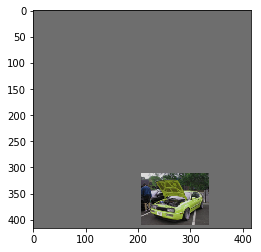

In [80]:
plt.imshow(image[ch][0])
plt.show()

In [86]:
arrpc = abox[0][ch][0]
boxc = np.where(arrpc[:,:,:,4] > 0 )
boxc

(array([11]), array([8]), array([0]))

In [87]:
box = boxc
arrp= arrpc
for i in range(len(box[0])):
    s = np.array(box)
    #print( i*5 )
    stp = i
   
    print( "({},{},{})".format(s[0,stp],s[1,stp],s[2,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

(11,8,0)
[0.6610577  0.87259614 0.2451923  0.19951923 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------
